In [1]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from xgboost import plot_importance
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
identifier_name = 'flight_id'

features_names = [
    'month-day',
    'month',
    'day_in_month',
    'adep', 
    'country_code_adep', 
    'ades', 
    'country_code_ades', 
    'aircraft_type', 
    'wtc', 
    'airline', 
    'flight_duration', 
    'taxiout_time', 
    'flown_distance', 
    'actual_offblock_time_hour', 
    'actual_offblock_time_minute', 
    'actual_offblock_time_hour_minute', 
    'arrival_time_hour', 
    'arrival_time_minute', 
    'arrival_time_hour_minute'
]

target_name = 'tow'

global_random_state = 123

In [3]:
encoded_challenge_set = pd.read_csv('../../data/encoded_challenge_set.csv')

# Pick up features from dataset
features = encoded_challenge_set[features_names]

# Pick up target from dataset
target = encoded_challenge_set[target_name]

In [4]:
# Function to score model using Root Mean Square Error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# Create a scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Make cross validation strategy
cv_strategy = KFold(n_splits=3, shuffle=True, random_state=global_random_state)

# Function to print the best parameters and best RMSE score after tunning
def print_model_score(grid_search):
    print("Best Parameters:", grid_search.best_params_)
    print("\nBest Score (Root Mean Squared Error):", grid_search.best_score_)

In [5]:
param_grid = {
    'n_estimators': list(range(1,102,15)),
    'max_depth': list(range(1, 11, 3)),
    'learning_rate': [x / 10 for x in list(range(1, 10, 3))],
    'subsample': [x / 10 for x in list(range(1, 11, 3))],
    'colsample_bytree': [x / 10 for x in list(range(1, 11, 3))]
}

model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    eval_metric='rmse',
    random_state=global_random_state
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', # Use RMSE (negative because scikit-learn maximizes scores)
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(features, target)

best_params = grid_search.best_params_
print("Best parameters:", best_params)
print("Best RMSE:", -grid_search.best_score_) # Negate the score to get RMSE

Fitting 3 folds for each of 1344 candidates, totalling 4032 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.4, 'max_depth': 10, 'n_estimators': 91, 'subsample': 1.0}
Best RMSE: 3565.1487678537633


<Figure size 1000x800 with 0 Axes>

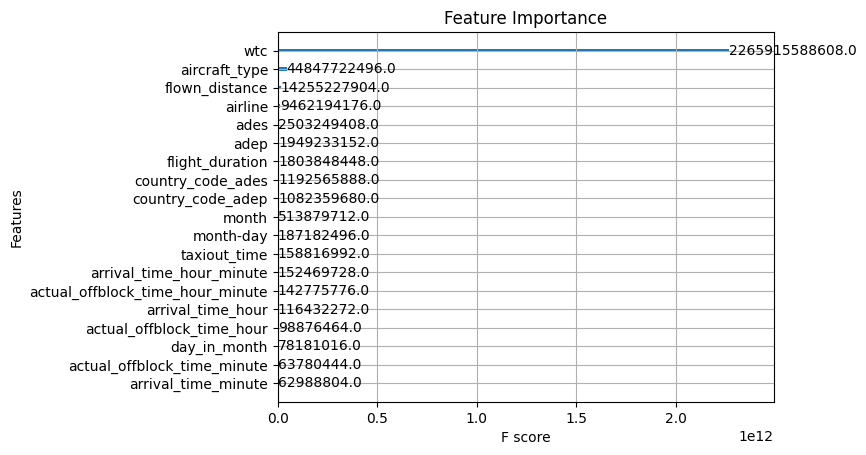

In [6]:
best_model = grid_search.best_estimator_

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_model, importance_type='gain')
plt.title('Feature Importance')
plt.show()

In [9]:
def evaluate_model(model, data_df, features_columns, target_column):
    features = data_df[features_columns]
    target = data_df[target_column]
    X_array = features.values
    y_array = target.values
    rmse_scores = []
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X_array):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse_scores.append(rmse(y_test, y_pred))
    return np.mean(rmse_scores)

In [10]:
xgb_model = xgb.XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    objective='reg:squarederror', 
    eval_metric='rmse',
    random_state=global_random_state
)

rmse_score = evaluate_model(
    model=xgb_model, 
    data_df=encoded_challenge_set, 
    features_columns=features_names, 
    target_column=target_name
)
print("Evaluation RMSE:", rmse_score)

Evaluation RMSE: 3583.249286445332
